In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras

## Data loading: Training set

### Data Exploration

In [6]:
base_path = 'dataset\\train'
resolutions = []
for category_name in os.listdir(base_path):
    category_path = os.path.join(base_path, category_name)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image = plt.imread(image_path)
        height, width = image.shape[:2]
        resolutions.append((height, width))

In [7]:
df = pd.DataFrame(resolutions)
df.describe()

,0,1
count,6552.000000,6552.000000
mean,534.322039,630.378358
std,75.299123,95.926038
min,500.000000,500.000000
25%,500.000000,501.000000
50%,500.000000,667.000000
75%,501.000000,699.000000
max,1168.000000,1024.000000


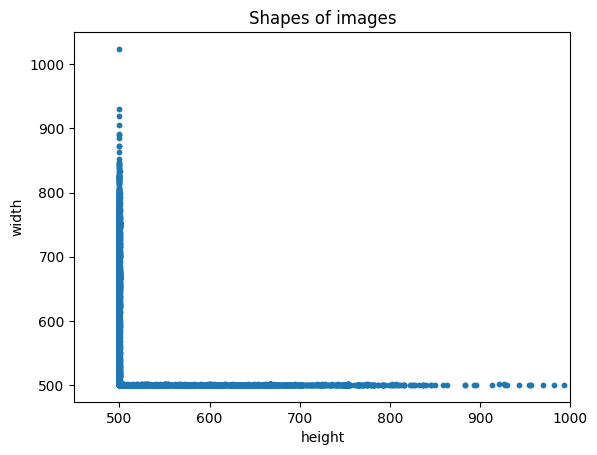

In [9]:
plt.scatter(df[0], df[1], s=10)
plt.xlabel("height")
plt.ylabel("width")
plt.title("Shapes of images")
plt.xlim([450, 1000])
plt.show()

### Training

In [10]:
# Set parameters
target_size = (64, 64)
batch_size = 128
num_classes = 102


def load_dataset(base_path, shuffle):
    # Data augmentation and normalization for better generalization
    datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255, # Add Rescaling layer to normalize pixel values to [0, 1]
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    dataset = datagen.flow_from_directory(
        base_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle,
        seed=1
    )
    return dataset


# Load datasets
train_dataset = load_dataset('dataset/train', shuffle=True)
validation_dataset = load_dataset('dataset/valid', shuffle=False)

Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


## Model Architecture

### CNN

In [11]:
def train_model(model):
   # Adjusting the learning rate during training
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.1,  # Start with a learning rate of 0.01
        decay_steps=10000,  # Reduce the learning rate every 10,000 steps
        decay_rate=0.9  # Multiply by 0.9 at each decay step
    )
    
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=10,  # Stop if val_loss doesn't improve for 5 consecutive epochs
        restore_best_weights=True  # Restore the best model weights
    )

    opt = keras.optimizers.RMSprop(learning_rate=lr_schedule)

    # Compile the model for training
    net.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt,
                metrics=['accuracy'])

    history = net.fit(
        train_dataset,
        batch_size=128,
        epochs=150,  # Train for 150 epochs, but early stopping might stop earlier
        validation_data=validation_dataset,
        callbacks=[early_stop],
        verbose=1
    )

    return history

In [12]:
inputs = keras.Input((target_size[0], target_size[1], 3))

x = inputs

x = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(2)(x)

x = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(2)(x)

x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net = keras.Model(inputs, outputs)

# Visualization in tabular form
net.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 102)                 │          13,158 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,574 (349.90 KB)

 Trainable params: 89,190 (348.40 KB)

 Non-trainable params: 384 (1.50 KB)

In [13]:
# Visualization in graphical form
keras.utils.plot_model(net, to_file='model.png')

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [14]:
history = train_model(net)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.0512 - loss: 5.9476 - val_accuracy: 0.0171 - val_loss: 20.3725
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.1112 - loss: 3.9075 - val_accuracy: 0.0477 - val_loss: 7.5784
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.1540 - loss: 3.6284 - val_accuracy: 0.1112 - val_loss: 4.9946
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.1923 - loss: 3.4655 - val_accuracy: 0.0795 - val_loss: 5.2919
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.1819 - loss: 3.4451 - val_accuracy: 0.0905 - val_loss: 5.3756
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.2061 - loss: 3.3858 - val_accuracy: 0.2139 - val_loss: 3.3842
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.2242 - loss: 3.2884 - val_accuracy: 0.1284 - val_loss: 5.1903
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.2268 - loss: 3.3595 - val_accuracy: 0.1467 - 

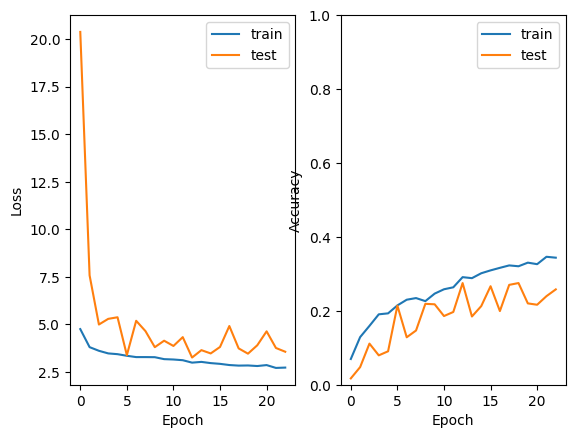

In [15]:
# Visualization of the learning curves
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim((0, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [16]:
# Evaluation
score = net.evaluate(validation_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - accuracy: 0.2637 - loss: 3.4219
Test loss: 3.274125099182129
Test accuracy: 0.2799510955810547


In [17]:
# Inference
yc_pred = net.predict(validation_dataset)
print('Prediction shape (probability distribution):', yc_pred.shape)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step
Prediction shape (probability distribution): (818, 102)


In [18]:
# Selection of the highest-probability class for each test sample
y_pred = np.argmax(yc_pred, axis=1)
print('Prediction shape (argmax):', y_pred.shape)

Prediction shape (argmax): (818,)


In [19]:
# Define mini-batch size
batch_size = 1 # Adjust based on available memory

# Predict in batches
y_pred_probs = []
y_true = []

for x_batch, y_batch in validation_dataset:
    y_pred_probs.append(net.predict(x_batch, batch_size=batch_size))
    y_true.append((y_batch))  # Convert Tensor to NumPy array

    # Stop early if the entire dataset is processed (for tf.data.Dataset)
    if len(y_true) * batch_size >= len(validation_dataset):  
        break

# Concatenate results
y_pred_probs = np.concatenate(y_pred_probs, axis=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate(y_true, axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Compute classification report
print(classification_report(y_true_classes, y_pred_classes))

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         4
           2       0.60      0.50      0.55         6
           3       0.17      0.20      0.18         5
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        10
           6       0.16      0.60      0.25         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         2
          11       0.73      0.50      0.59        16
   

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.

Confusion matrix:


Text(0, 0.5, 'Ground truth class')

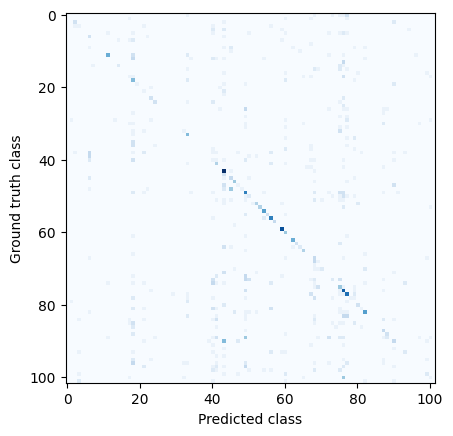

In [20]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 


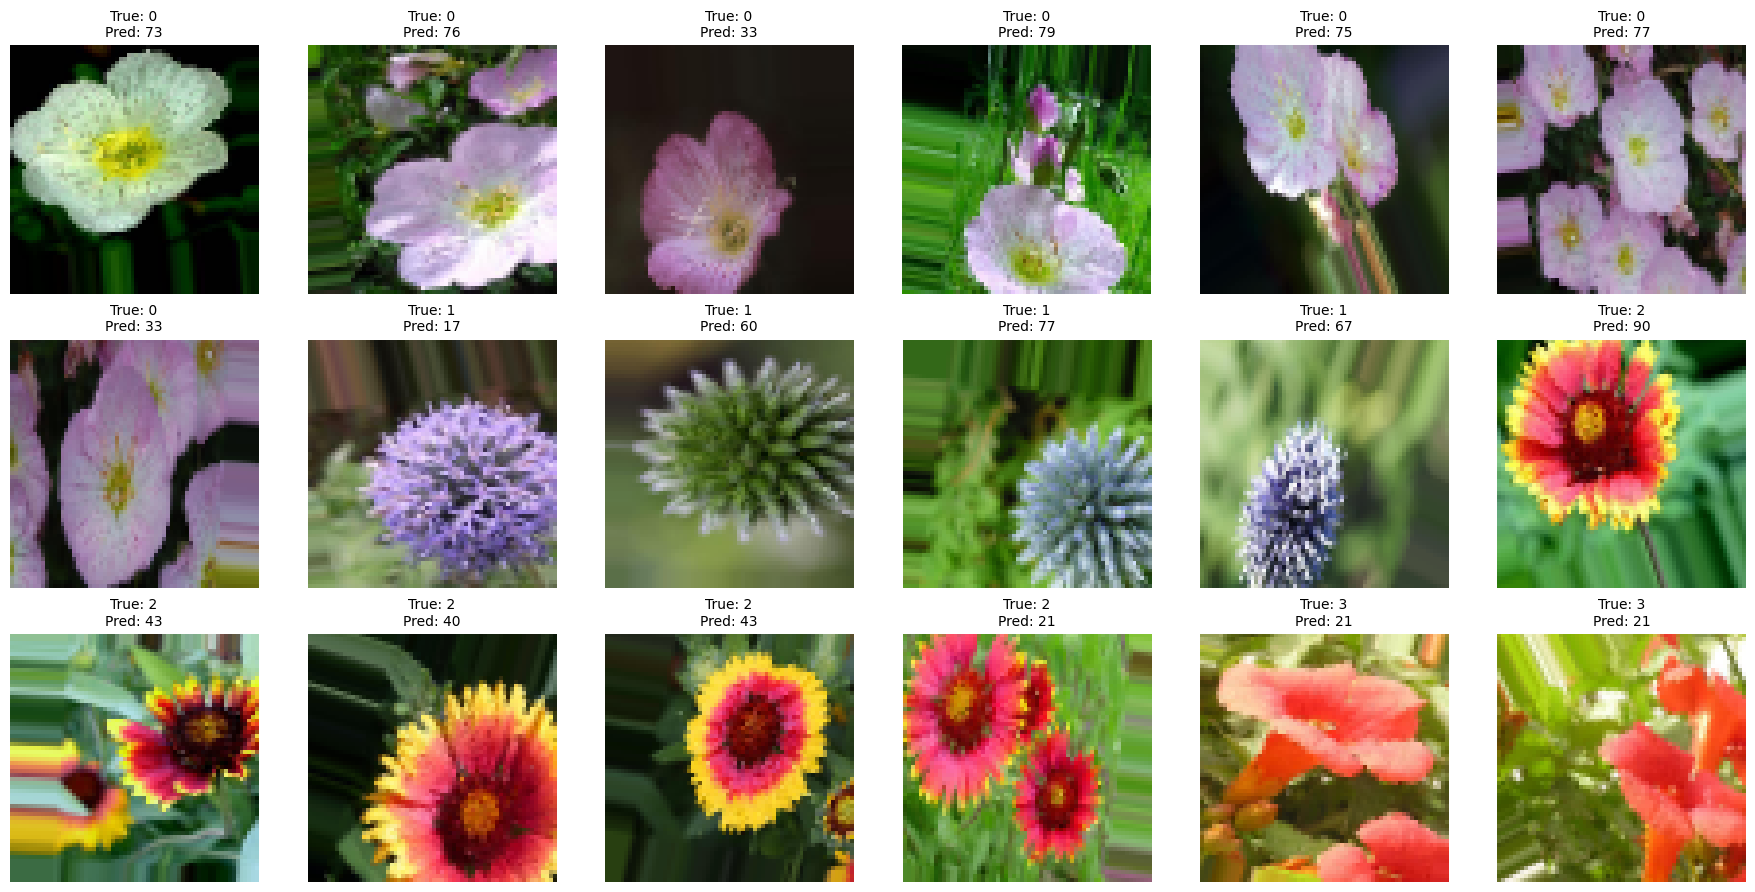

In [21]:
# Define mini-batch processing
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

for x_batch, y_batch in validation_dataset:
    y_pred_batch = np.argmax(net.predict(x_batch), axis=1)  # Predict batch
    y_true_batch = np.argmax(np.array(y_batch), axis=1)       # Convert true labels

    # Find misclassified indices within this batch
    batch_misclassified_idx = np.where(y_pred_batch != y_true_batch)[0]
    
    if len(batch_misclassified_idx) > 0:
        misclassified_images.extend(x_batch[batch_misclassified_idx])  # Store images
        misclassified_true_labels.extend(y_true_batch[batch_misclassified_idx])  # True labels
        misclassified_pred_labels.extend(y_pred_batch[batch_misclassified_idx])  # Pred labels

    # Stop early if we have enough images for display
    if len(misclassified_images) >= 18:
        break

# Convert to NumPy arrays
misclassified_images = np.array(misclassified_images[:18])  
misclassified_true_labels = np.array(misclassified_true_labels[:18])
misclassified_pred_labels = np.array(misclassified_pred_labels[:18])

# Plot misclassified images (3 rows, 6 columns)
plt.figure(figsize=(18, 9))  # Adjust figure size for better visibility
for i in range(18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(misclassified_images[i])  # Display the image
    plt.title(f'True: {misclassified_true_labels[i]}\nPred: {misclassified_pred_labels[i]}', fontsize=10)
    plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()


In [ ]:
net.save('CNN_flower_model.keras')